In [36]:
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 📂 Step 1: Load All CSVs
files = sorted(glob.glob("../../data/fp/ua_group_taxonomy_distribution_*.csv"))
all_df = []

for f in files:
    df = pd.read_csv(f)
    # Extract range like 2025-03-15_to_2025-03-17 from filename
    label = os.path.basename(f).replace("ua_group_taxonomy_distribution_", "").replace(".csv", "")
    df["date_range"] = label
    all_df.append(df)

df_all = pd.concat(all_df, ignore_index=True)
print(f"Loaded {len(files)} files and {len(df_all)} total rows.")


Loaded 4 files and 267 total rows.


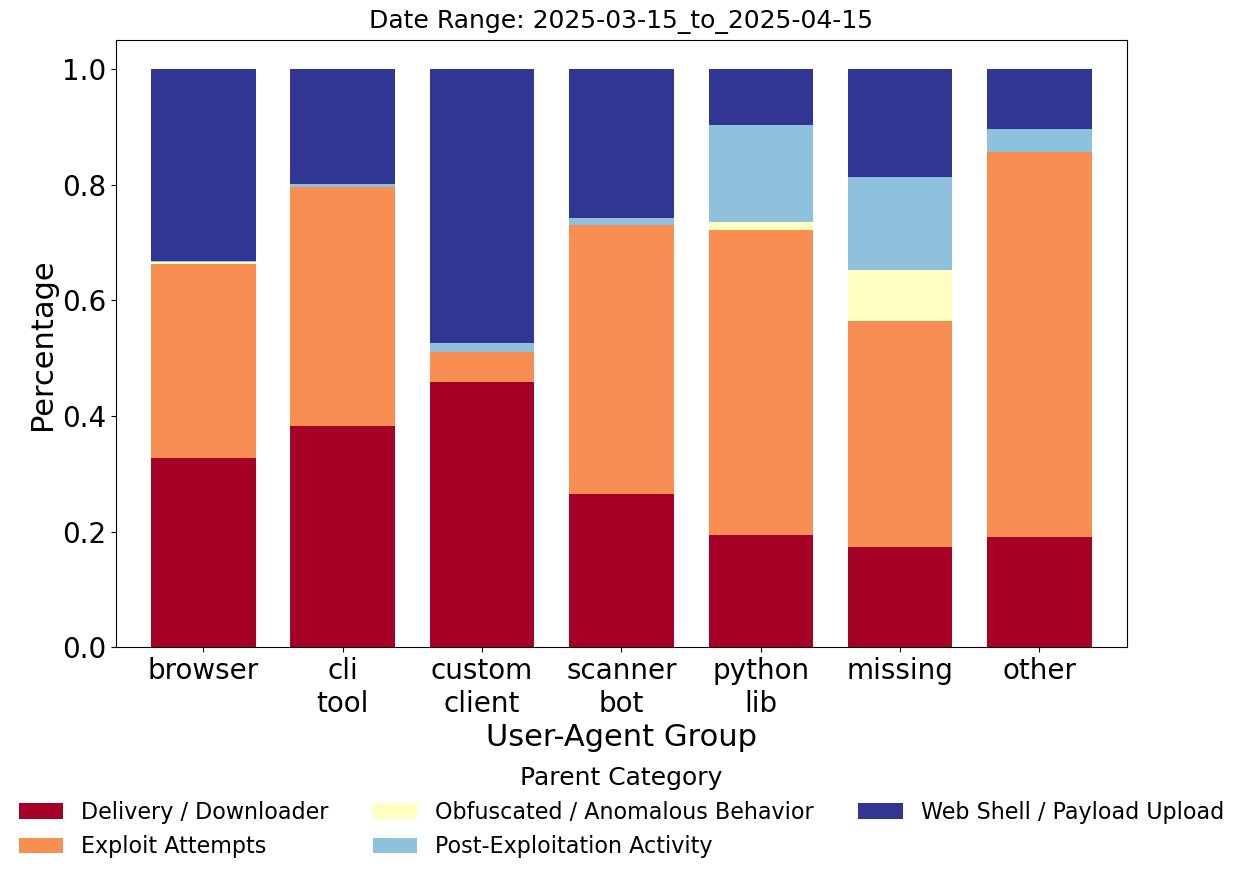

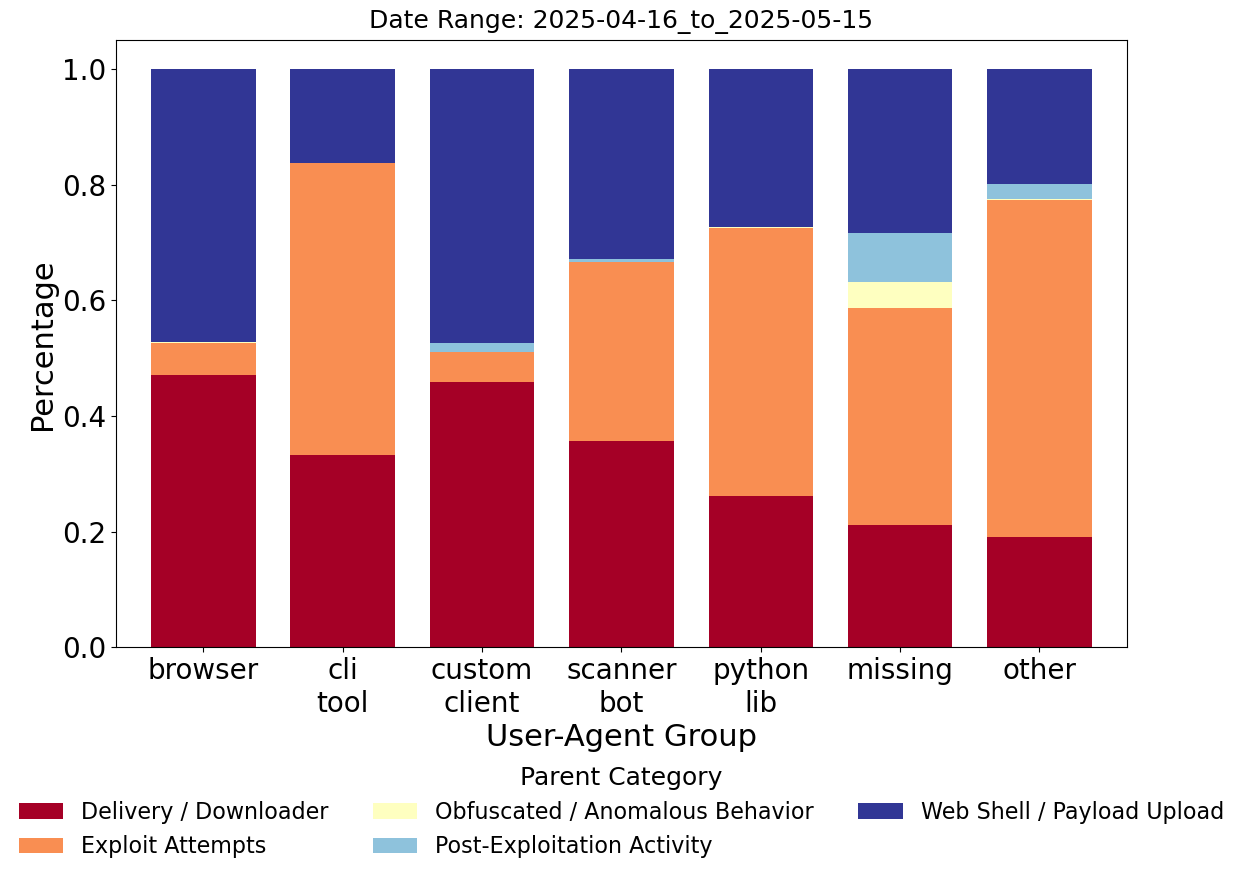

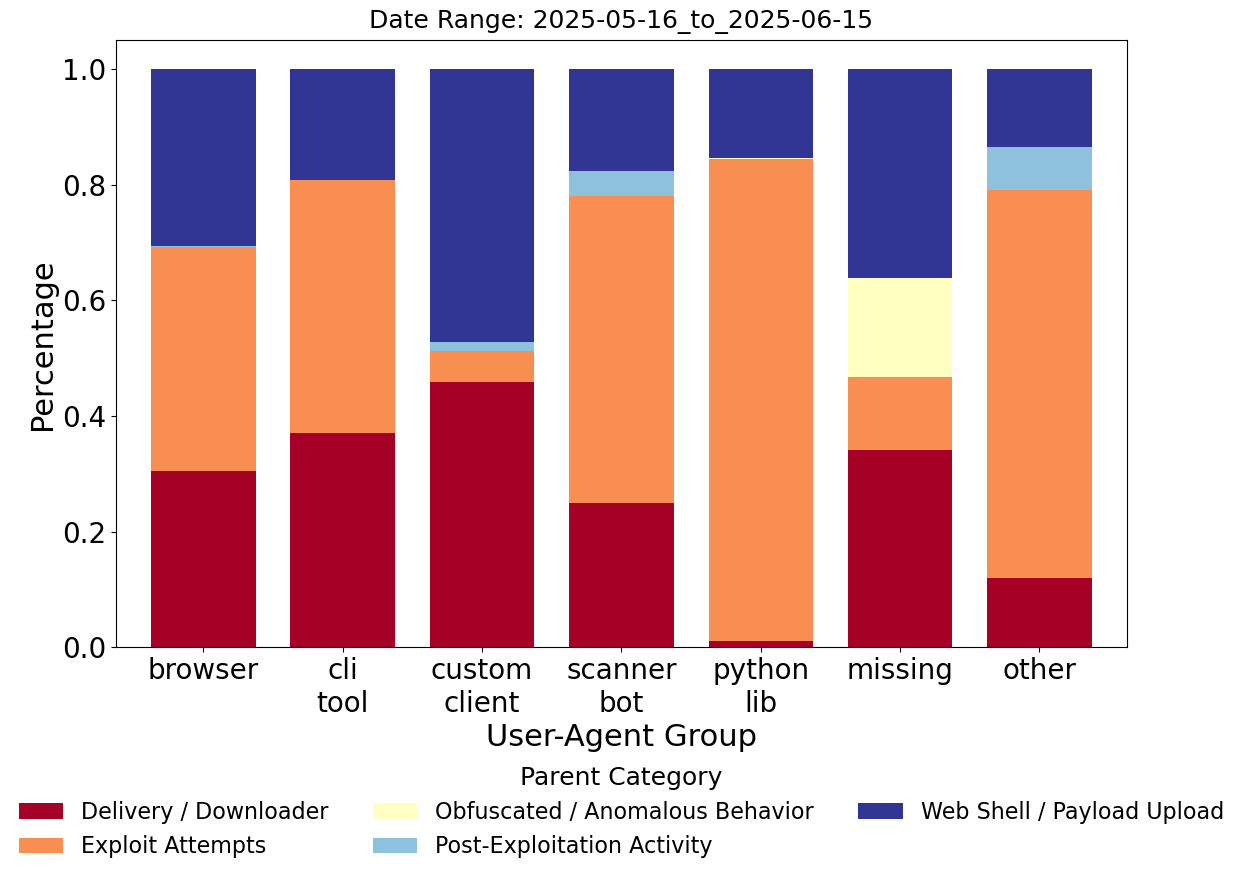

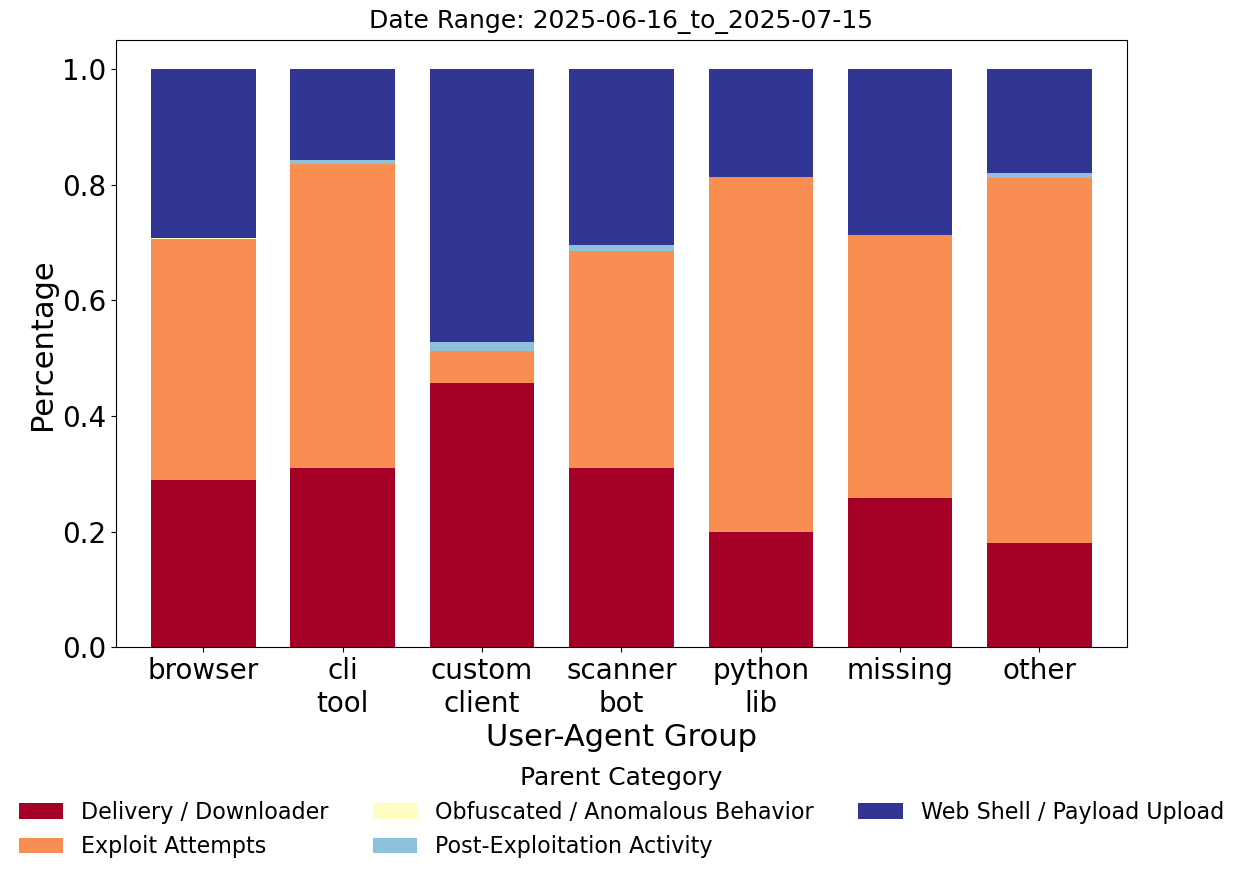

In [38]:
# === Fixed order of user-agent groups (based on union or importance)
fixed_ua_order = [
    "browser", "cli_tool", "custom_client", "scanner_bot",
    "python_lib", "missing", "other"
]
for label, df_sub in df_all.groupby("date_range"):
    pivot = df_sub.groupby(["ua_group", "Parent_Category"])["percentage"].sum().reset_index()
    plot_data = pivot.pivot(index="ua_group", columns="Parent_Category", values="percentage").fillna(0)
    # Ensure only valid rows are kept and ordered
    plot_data = plot_data.reindex(fixed_ua_order).dropna(how='all')


    fig, ax = plt.subplots(figsize=(12, 8))
    plot_data.plot(kind="bar", stacked=True, ax=ax, colormap="RdYlBu", width=0.75)

    xtick_labels = [label.replace("_", "\n") for label in plot_data.index]
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center", fontsize=20)

    ax.set_ylabel("Percentage", fontsize=22)
    ax.set_xlabel("User-Agent Group", fontsize=22)
    ax.tick_params(axis='y', labelsize=20)

    # ✅ Date range text ABOVE the plot
    ax.text(
        0.5, 1.01, f"Date Range: {label}",
        fontsize=18,
        ha='center',
        va='bottom',
        transform=ax.transAxes
    )

    # ✅ Multi-line legend at bottom
    handles, labels_ = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=labels_,
        title="Parent Category",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.38),
        ncol=3,
        fontsize=16,
        title_fontsize=18,
        frameon=False
    )

    plt.subplots_adjust(left=0.08, right=0.98, top=0.90, bottom=0.42)
    plt.tight_layout()
    plt.show()


In [44]:
import os
import pandas as pd
from collections import defaultdict

# === CONFIG ===
DATA_FOLDER = "../../data/fp"  # Update to your folder
prefix = "ua_group_taxonomy_distribution_"

# === Load Matching Files ===
files = sorted([
    f for f in os.listdir(DATA_FOLDER)
    if f.startswith(prefix) and f.endswith(".csv")
])

# === Storage Format ===
# {date_range: {parent_category: {ua_group: percentage}}}
data_matrix = defaultdict(lambda: defaultdict(dict))

# === Process Each File ===
for fname in files:
    date_range = fname.replace(prefix, "").replace(".csv", "")
    df = pd.read_csv(os.path.join(DATA_FOLDER, fname))

    # Compute parent-level distribution per ua_group
    grouped = (
        df.groupby(["ua_group", "Parent_Category"])["percentage"]
        .sum()
        .reset_index()
    )

    for _, row in grouped.iterrows():
        ua = row["ua_group"]
        parent = row["Parent_Category"]
        pct = row["percentage"]
        data_matrix[date_range][parent][ua] = f"{pct:.1%}"

# === Convert to DataFrame Format ===
# Columns: [Date, Category, browser, cli_tool, ...]
records = []
ua_groups = sorted({ua for date in data_matrix.values() for cat in date.values() for ua in cat})

for date_range, category_map in data_matrix.items():
    for parent_cat, ua_pct_map in category_map.items():
        row = {
            "Date Range": date_range,
            "Category": parent_cat
        }
        for ua in ua_groups:
            row[ua] = ua_pct_map.get(ua, "—")
        records.append(row)

df_result = pd.DataFrame(records)

# Optional: order columns
ordered_cols = ["Date Range", "Category"] + ua_groups
df_result = df_result[ordered_cols]

# === Save or use for LaTeX conversion ===
# df_result.to_markdown("ua_parent_horizontal.md", index=False)
df_result.to_csv("ua_parent_horizontal.csv", index=False)


In [46]:
df_result

,Date Range,Category,browser,cli_tool,custom_client,missing,other,python_lib,scanner_bot
0,2025-03-15_to_2025-04-15,Delivery / Downloader,32.7%,38.3%,45.9%,17.3%,19.1%,19.4%,26.6%
1,2025-03-15_to_2025-04-15,Exploit Attempts,33.5%,41.3%,5.2%,39.2%,66.6%,52.8%,46.4%
2,2025-03-15_to_2025-04-15,Obfuscated / Anomalous Behavior,0.4%,—,—,8.8%,—,1.4%,—
3,2025-03-15_to_2025-04-15,Post-Exploitation Activity,0.2%,0.5%,1.6%,16.1%,3.9%,16.7%,1.1%
4,2025-03-15_to_2025-04-15,Web Shell / Payload Upload,33.1%,19.9%,47.3%,18.7%,10.4%,9.7%,25.8%
5,2025-04-16_to_2025-05-15,Delivery / Downloader,47.1%,33.3%,45.9%,21.2%,19.2%,26.2%,35.7%
6,2025-04-16_to_2025-05-15,Exploit Attempts,5.5%,50.4%,5.2%,37.4%,58.2%,46.3%,30.9%
7,2025-04-16_to_2025-05-15,Obfuscated / Anomalous Behavior,0.1%,—,—,4.5%,0.1%,0.1%,—
8,2025-04-16_to_2025-05-15,Post-Exploitation Activity,0.0%,—,1.6%,8.6%,2.6%,0.1%,0.5%
9,2025-04-16_to_2025-05-15,Web Shell / Payload Upload,47.2%,16.3%,47.3%,28.3%,20.0%,27.3%,32.9%
